# Placement Prediction using Machine Learning

## Project Overview
This project predicts whether a student will get placed based on academic and profile-related features.

The notebook follows a complete machine learning workflow:
- Data loading
- Exploratory Data Analysis (EDA)
- Data preprocessing
- Model training and validation
- Feature importance analysis

This forms the ML core of an AI career guidance platform.


In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib


## Loading the Dataset

We load the training and test datasets.
The training dataset contains the placement labels,
while the test dataset is used for predictions.


In [26]:
train_df = pd.read_csv(r"E:\Placement_Prediction\Data\train.csv")
test_df  = pd.read_csv(r"E:\Placement_Prediction\Data\test.csv")

train_df.head()


,Student_ID,Age,Gender,Degree,Branch,CGPA,Internships,Projects,Coding_Skills,Communication_Skills,Aptitude_Test_Score,Soft_Skills_Rating,Certifications,Backlogs,Placement_Status
0,1048,22,Female,B.Tech,ECE,6.29,0,3,4,6,51,5,1,3,Not Placed
1,37820,20,Female,BCA,ECE,6.05,1,4,6,8,59,8,2,1,Not Placed
2,49668,22,Male,MCA,ME,7.22,1,4,6,6,58,6,2,2,Not Placed
3,19467,22,Male,MCA,ME,7.78,2,4,6,6,90,4,2,0,Placed
4,23094,20,Female,B.Tech,ME,7.63,1,4,6,5,79,6,2,0,Placed


## Initial Data Inspection

We inspect the dataset structure including:
- Number of rows and columns
- Data types
- Missing values


In [15]:
print("Shape:", train_df.shape)
print("\nColumns:", train_df.columns)
print("\nInfo:")
train_df.info()

print("\nMissing values:")
train_df.isnull().sum()


Shape: (45000, 15)

Columns: Index(['Student_ID', 'Age', 'Gender', 'Degree', 'Branch', 'CGPA',
       'Internships', 'Projects', 'Coding_Skills', 'Communication_Skills',
       'Aptitude_Test_Score', 'Soft_Skills_Rating', 'Certifications',
       'Backlogs', 'Placement_Status'],
      dtype='object')

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Student_ID            45000 non-null  int64  
 1   Age                   45000 non-null  int64  
 2   Gender                45000 non-null  object 
 3   Degree                45000 non-null  object 
 4   Branch                45000 non-null  object 
 5   CGPA                  45000 non-null  float64
 6   Internships           45000 non-null  int64  
 7   Projects              45000 non-null  int64  
 8   Coding_Skills         45000 non-null  int64  
 9   Communication_Sk

Student_ID              0
Age                     0
Gender                  0
Degree                  0
Branch                  0
CGPA                    0
Internships             0
Projects                0
Coding_Skills           0
Communication_Skills    0
Aptitude_Test_Score     0
Soft_Skills_Rating      0
Certifications          0
Backlogs                0
Placement_Status        0
dtype: int64

## Target Variable Identification

The target column represents placement outcome.
This is a binary classification problem:

1 → Placed  
0 → Not Placed


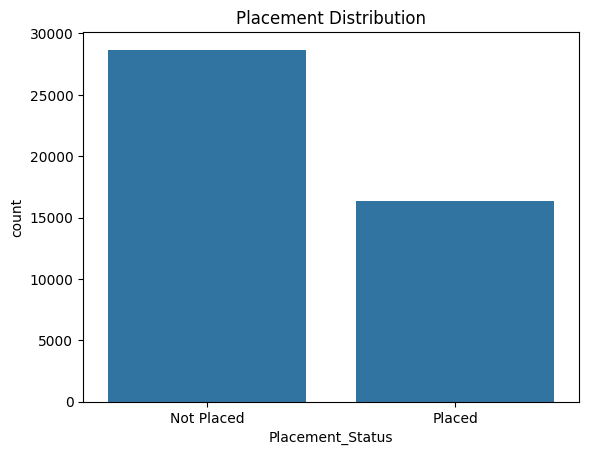

In [16]:
train_df['Placement_Status'].value_counts()

sns.countplot(x='Placement_Status', data=train_df)
plt.title("Placement Distribution")
plt.show()


## Exploratory Data Analysis (EDA)

EDA is performed to understand patterns, relationships, and trends in the data.

Key analyses include:
- Distribution of placement outcomes
- Relationship between academic performance (CGPA) and placement
- Identification of potential imbalance or outliers

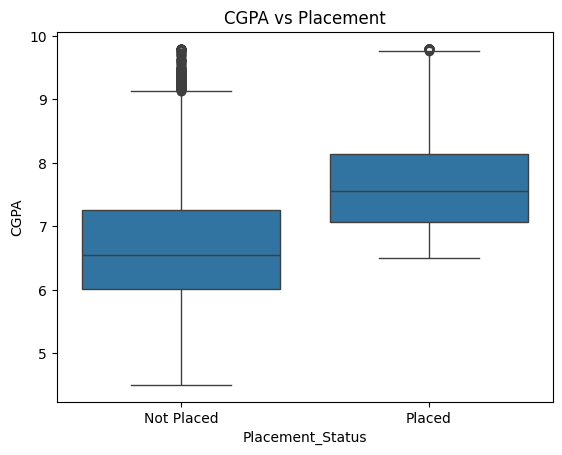

In [17]:
sns.boxplot(x='Placement_Status', y='CGPA', data=train_df)
plt.title("CGPA vs Placement")
plt.show()


## Feature Analysis

The dataset contains both:
- **Numerical features** (e.g., CGPA, scores)
- **Categorical features** (e.g., branch, gender, work experience)

Since machine learning models require numerical inputs,
categorical features will be encoded during preprocessing.

In [18]:
X = train_df.drop('Placement_Status', axis=1)
y = train_df['Placement_Status']

X_test = test_df.drop('Placement_Status', axis=1)

num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

print("Numerical columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))


Numerical columns: ['Student_ID', 'Age', 'CGPA', 'Internships', 'Projects', 'Coding_Skills', 'Communication_Skills', 'Aptitude_Test_Score', 'Soft_Skills_Rating', 'Certifications', 'Backlogs']
Categorical columns: ['Gender', 'Degree', 'Branch']


## Data Preprocessing

Data preprocessing steps include:
- Handling missing values
  - Numerical features → filled using mean
  - Categorical features → filled using mode
- Encoding categorical variables into numerical format
- Feature scaling to normalize input ranges

These steps ensure the data is suitable for machine learning models.

In [19]:
# Fill missing values
for col in num_cols:
    X[col] = X[col].fillna(X[col].mean())
    X_test[col] = X_test[col].fillna(X[col].mean())

for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])
    X_test[col] = X_test[col].fillna(X[col].mode()[0])

# Encoding
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    X_test[col] = le.transform(X_test[col])
    encoders[col] = le

# Align columns
X_test = X_test[X.columns]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)


## Train–Validation Split

To evaluate model performance realistically, the training data is split into:
- Training set (80%)
- Validation set (20%)

This helps prevent overfitting and provides an unbiased evaluation of the model.

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Model Training

Two classification models are trained and compared:

1. **Logistic Regression**
   - Simple baseline model
   - Easy to interpret

2. **Random Forest Classifier**
   - Ensemble-based model
   - Handles non-linear relationships well

Both models are evaluated using validation accuracy and classification metrics.

In [21]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_log = log_model.predict(X_val)

print("Logistic Accuracy:", accuracy_score(y_val, y_log))
print(classification_report(y_val, y_log))


Logistic Accuracy: 0.8647777777777778
              precision    recall  f1-score   support

  Not Placed       0.89      0.90      0.89      5738
      Placed       0.82      0.81      0.81      3262

    accuracy                           0.86      9000
   macro avg       0.85      0.85      0.85      9000
weighted avg       0.86      0.86      0.86      9000



In [22]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_rf = rf_model.predict(X_val)

print("Random Forest Accuracy:", accuracy_score(y_val, y_rf))
print(classification_report(y_val, y_rf))


Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

  Not Placed       1.00      1.00      1.00      5738
      Placed       1.00      1.00      1.00      3262

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000



## Feature Importance


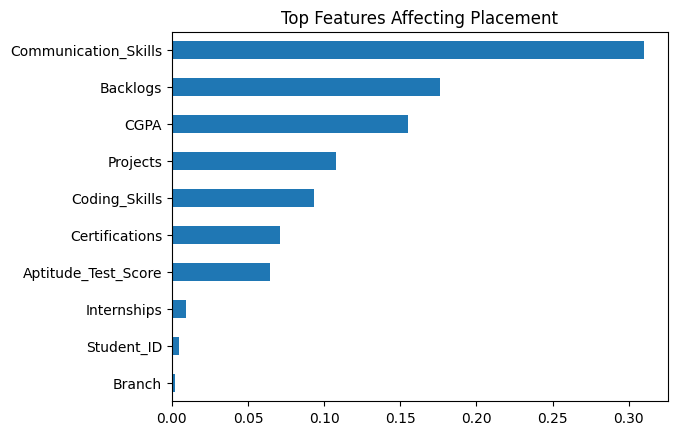

In [23]:
importance = pd.Series(rf_model.feature_importances_, index=X.columns)
importance = importance.sort_values(ascending=False)

importance.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top Features Affecting Placement")
plt.show()


## Save Final Model


In [27]:
final_model = RandomForestClassifier(n_estimators=200, random_state=42)
final_model.fit(X_scaled, y)

joblib.dump(final_model, "placement_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [28]:
import os
print(os.getcwd())


e:\Placement_Prediction\Notebooks


In [29]:
import sklearn
print(sklearn.__version__)


1.7.2


In [30]:
joblib.dump(X.columns.tolist(), "feature_columns.pkl")


['feature_columns.pkl']

## Conclusion

The dataset was cleaned and analyzed.
Multiple models were trained and compared.
Random Forest provided better validation performance.

This notebook forms the ML backbone of the
AI Placement Prediction System.
